In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d

import genjax
from genjax import gen, choice_map, vector_choice_map

import jax
from jax import jit, vmap
import jax.numpy as jnp


import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff

import trimesh

from bayes3d._mkl.utils import *
from bayes3d._mkl.importance import _importance_sampling


key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [3]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)

_segs  = _segs.reshape(-1,2,2)
_boxes = _boxes.reshape(-1,2,2)


def bounding_box(arr, pad=0):
    """Takes a point-like (last dim = 2) arr and returns its bounding box."""
    return jnp.array([
        [jnp.min(arr[...,0])-pad, jnp.min(arr[...,1])-pad],
        [jnp.max(arr[...,0])+pad, jnp.max(arr[...,1])+pad]
    ])
_bb = bounding_box(_segs)


_ps = np.concatenate([_xs, _hds[:,None]], axis=1)

_boxes[0], _T

(array([[ 7.1517381 , 17.62209524],
       [ 7.8517381 , 17.62209524]]), 50)

In [4]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)

map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)
['object_0', 'object_1']


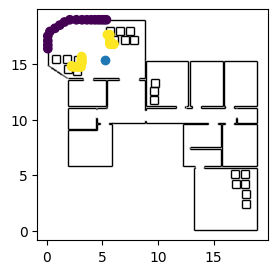

In [5]:
w = 50
h = 1

near = .01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0,:,[0,2]].T
xs = apply_2dpose(p, xs)


# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="k", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2)

## Make Model

In [6]:
from genjax.generative_functions.distributions import ExactDensity
from bayes3d.likelihood import threedp3_likelihood
from genjax import tfp_uniform as uniform

?threedp3_likelihood

Signature:
threedp3_likelihood(
    observed_xyz: jax.Array,
    rendered_xyz: jax.Array,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size,
)
Docstring: <no docstring>
File:      ~/workspace/bayes3d/bayes3d/likelihood.py
Type:      function

In [7]:
def make_img_dist(w:int, zmax:float):

    

    class B3DImageDist(ExactDensity):
        def sample(self, key, Y, sig, outlier):
            # TODO: write this method
            return Y[:,:,:3]

        def logpdf(self, X, Y, sig, outlier):
            # Here, zmax plays the role of the outlier volume
            return threedp3_likelihood(X,Y, sig**2, outlier, zmax, w)
        
    return B3DImageDist()


def make_model(w:int, zmax:float):

    # TODO: Note that we shouldn't have to do this! 
    # There is an underlying bug. Ask McCoy if the issue got resolved yet.
    b3d_img_dist = make_img_dist(w, zmax)

    img_dist = make_img_dist(w, zmax)
    
    @gen
    def model(inds):

        x  = uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
        # Lift pose to 3D and 
        # render an image
        Y = render(lift_pose(x,hd), inds)

        # Sample Hyper Parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        X = img_dist(Y, sig, outlier) @ "X"

        return X
    
    return model


In [8]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': p[ 2],
        'sig':     sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()

eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))

In [9]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd) @ "hd"
    
    return pack_2dpose(x, adjust_angle(hd))

In [10]:
def get_linear_grid(shape, args):
    n = len(shape)
    vs = jnp.stack(jnp.meshgrid(
        *[jnp.linspace(*a, d) for a,d in zip(args, shape)],
    indexing='ij'), axis=-1)

    return vs


def make_inference_grid(tr, shape, dx, dhd, sig=(0.01, 0.5), outlier=(0.001, 0.5)):
    args  = (
        (tr['x'][0]-dx,tr['x'][0]+dx),
        (tr['x'][1]-dx,tr['x'][1]+dx),
        (tr['hd']-dhd,tr['hd']+dhd),
        sig,
        outlier,
    )
    return get_linear_grid(shape, args)


In [11]:
def plot_pose_grid(ax, vs, sc, p0, xs, logps, *, PAD=4, quantile=0.5):
    sc = sc.reshape(-1)
    vs = vs.reshape(-1, vs.shape[-1])
    logps = logps.reshape(-1,logps.shape[-1])
    order = jnp.argsort(sc)
    sc = sc[order]
    vs = vs[order]
    logps = logps[order]
    
    mask = sc > -jnp.inf
    sc = sc[mask]
    vs = vs[mask] 
    sc  = jnp.clip(sc, -1e6,  jnp.max(sc))
    sc  = jnp.clip(sc, jnp.quantile(sc, quantile), jnp.max(sc))
    cs  = plt.cm.viridis(plt.Normalize()(sc))

    a = vs[:,:2]
    b = a + 0.3*jax.vmap(unit_vec)(vs[:,2])

    seg_color = "k"

    
    # ---------------------
    ax.set_aspect(1)
    zoom_in(ax, jnp.mean(vs, axis=0)[:2], PAD)
    plot_segs(ax,  _segs, c=seg_color, zorder=2)
    plot_segs(ax, _boxes, c="lightgray", zorder=2)

    # cc  = jnp.clip(logps[-1], jnp.quantile(logps[-1], 0.2), jnp.quantile(logps[-1], 0.5))

    ax.scatter(*apply_2dpose(vs[-1,:3], xs).T, s=30, c=logps[-1], alpha=1., zorder=3, )


    ax.plot(
        *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
    c="r", zorder=4, linewidth=2)

    ax.add_collection(line_collection(a,b, c=cs, zorder=1, linewidth=2));


## Experiment

In [23]:
# Get true pose and observations
t0 = 40
p0 = _ps[t0]

X0  = render(lift_pose(p0[:2], p0[2]), inds=[0,1])
X0  = X0[:,:,:3]
xs = X0.reshape(-1,3)[:,[0,2]]


w     = 7
zmax  = 20.

obs = genjax.choice_map({"X":X0})

model = make_model(w, zmax)
N     = 10
key = keysplit(key)
(trs, ws, _) = _importance_sampling(key,
                                    model, (jnp.array([0]),), obs,  
                                    anchored_pose_prior, (p0, .5, 15), 
                                    N=N)

0 5
0.10235767 0.44882587


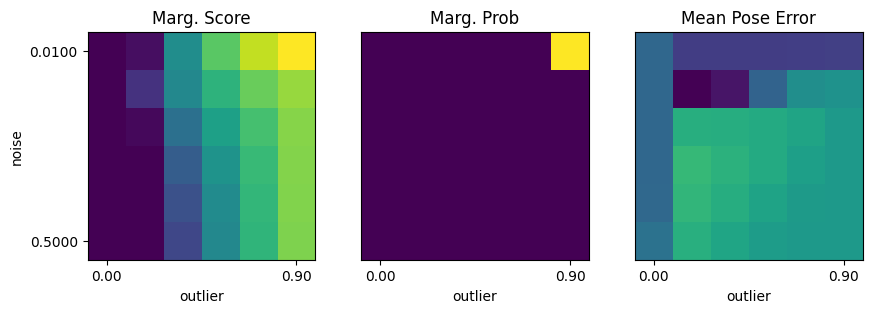

In [24]:
i = 0
tr = trs.slice(i)

dx  = 1.
dhd = 35/180*jnp.pi
shape = (5,5,5, 6,6)


# Grid
vs = make_inference_grid(tr, shape, dx, dhd,  sig=(0.01,0.5), outlier=(0.0,0.9))
vs_flat = vs.reshape(-1, len(shape))

# Grid -vs- True
xdist  = jnp.linalg.norm(vs_flat[:,:2]-p0[:2], axis=1)
hddist = jnp.abs(jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2]))
xdiff  = vs_flat[:,:2]-p0[:2]
hddiff = jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2])
diff = jnp.concatenate([xdiff,hddiff[:,None]], axis=-1)
err_flat = jnp.linalg.norm(diff, axis=-1)
err = err_flat.reshape(shape)





# Eval
key = keysplit(key)

sc_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
sc    = sc_flat.reshape(shape)


sc_marg = logsumexp(sc, axis=(0,1,2))
sc_marg = sc_marg - logsumexp(sc_marg)

sc_marg = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.25), jnp.max(sc_marg))

# Normalize along pose axes
# And compute the aver pose error
pr = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
dd = jnp.sum(pr*err, axis=(0,1,2))


imax = jnp.argmax(sc)
I = jnp.unravel_index(imax, shape)
ss, oo = I[3], I[4]
print(ss,oo)
print(jnp.min(err_flat), err_flat[imax])

# -----------------------------------------
fig, axs = plt.subplots(1,3,figsize=(10,4), sharex=True)
axs[0].set_title("Marg. Score")
axs[0].imshow(sc_marg )
axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
axs[0].set(
xlabel="outlier",
xticks=[0, shape[4]-1], 
xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
ylabel="noise",
yticks=[0, shape[3]-1], 
yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
)


axs[1].set_title("Marg. Prob")
axs[1].imshow(jnp.exp(sc_marg), vmin=0.0)
axs[1].set(
xlabel="outlier",
xticks=[0, shape[4]-1], 
xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
yticks=[],
)

axs[2].set_title("Mean Pose Error")
axs[2].imshow(dd, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis")
axs[2].set(
xlabel="outlier",
xticks=[0, shape[4]-1], 
xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
yticks=[],
);

In [25]:
I = argmax_axes(sc, axes=[0,1,2])



In [28]:
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider

@interact(
        i = IntSlider(min=0, max=N-1, step=1, value=0, continuous_update=False),
        num_x    = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_hd   = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_sig = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_out = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        sig = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.01,0.5], continuous_update=False),
        out = FloatRangeSlider(min=0, max=1.0, step=0.01, value=[0.0,0.9], continuous_update=False),
)
def func(i, num_x, num_hd, num_sig, num_out, sig, out):
        

        tr = trs.slice(i)

        dx  = 1.
        dhd = 35/180*jnp.pi
        shape = (num_x, num_x, num_hd, num_sig, num_out)


        # Grid
        vs = make_inference_grid(tr, shape, dx, dhd,  sig=sig, outlier=out)
        vs_flat = vs.reshape(-1, len(shape))

        # Grid -vs- True
        xdist  = jnp.linalg.norm(vs_flat[:,:2]-p0[:2], axis=1)
        hddist = jnp.abs(jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2]))
        xdiff  = vs_flat[:,:2]-p0[:2]
        hddiff = jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2])
        diff = jnp.concatenate([xdiff,hddiff[:,None]], axis=-1)
        err_flat = jnp.linalg.norm(diff, axis=-1)
        err = err_flat.reshape(shape)


        # Eval
        global key;
        key = keysplit(key)

        sc_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], jnp.sqrt(vs_flat[:,3]), vs_flat[:,4])
        sc    = sc_flat.reshape(shape)


        sc_marg = logsumexp(sc, axis=(0,1,2))
        sc_marg = sc_marg - logsumexp(sc_marg)

        sc_marg = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.25), jnp.max(sc_marg))

        # Normalize along pose axes
        # And compute the aver pose error
        pr = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
        dd = jnp.sum(pr*err, axis=(0,1,2))


        I = jnp.unravel_index(jnp.argmax(sc), shape)
        ss, oo = I[3], I[4]
        print(i, ss,oo)

        # -----------------------------------------
        fig, axs = plt.subplots(1,3,figsize=(10,4), sharex=True)
        axs[0].set_title("Marg. Score")
        axs[0].imshow(sc_marg )
        axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
        axs[0].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        ylabel="noise",
        yticks=[0, shape[3]-1], 
        yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )


        axs[1].set_title("Marg. Prob")
        axs[1].imshow(jnp.exp(sc_marg), vmin=0.0)
        axs[1].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
        )


        axs[2].set_title("Mean Pose Error")
        axs[2].imshow(dd, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis")
        axs[2].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
        );
        # fig.tight_layout()

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), IntSlider(value=5, …

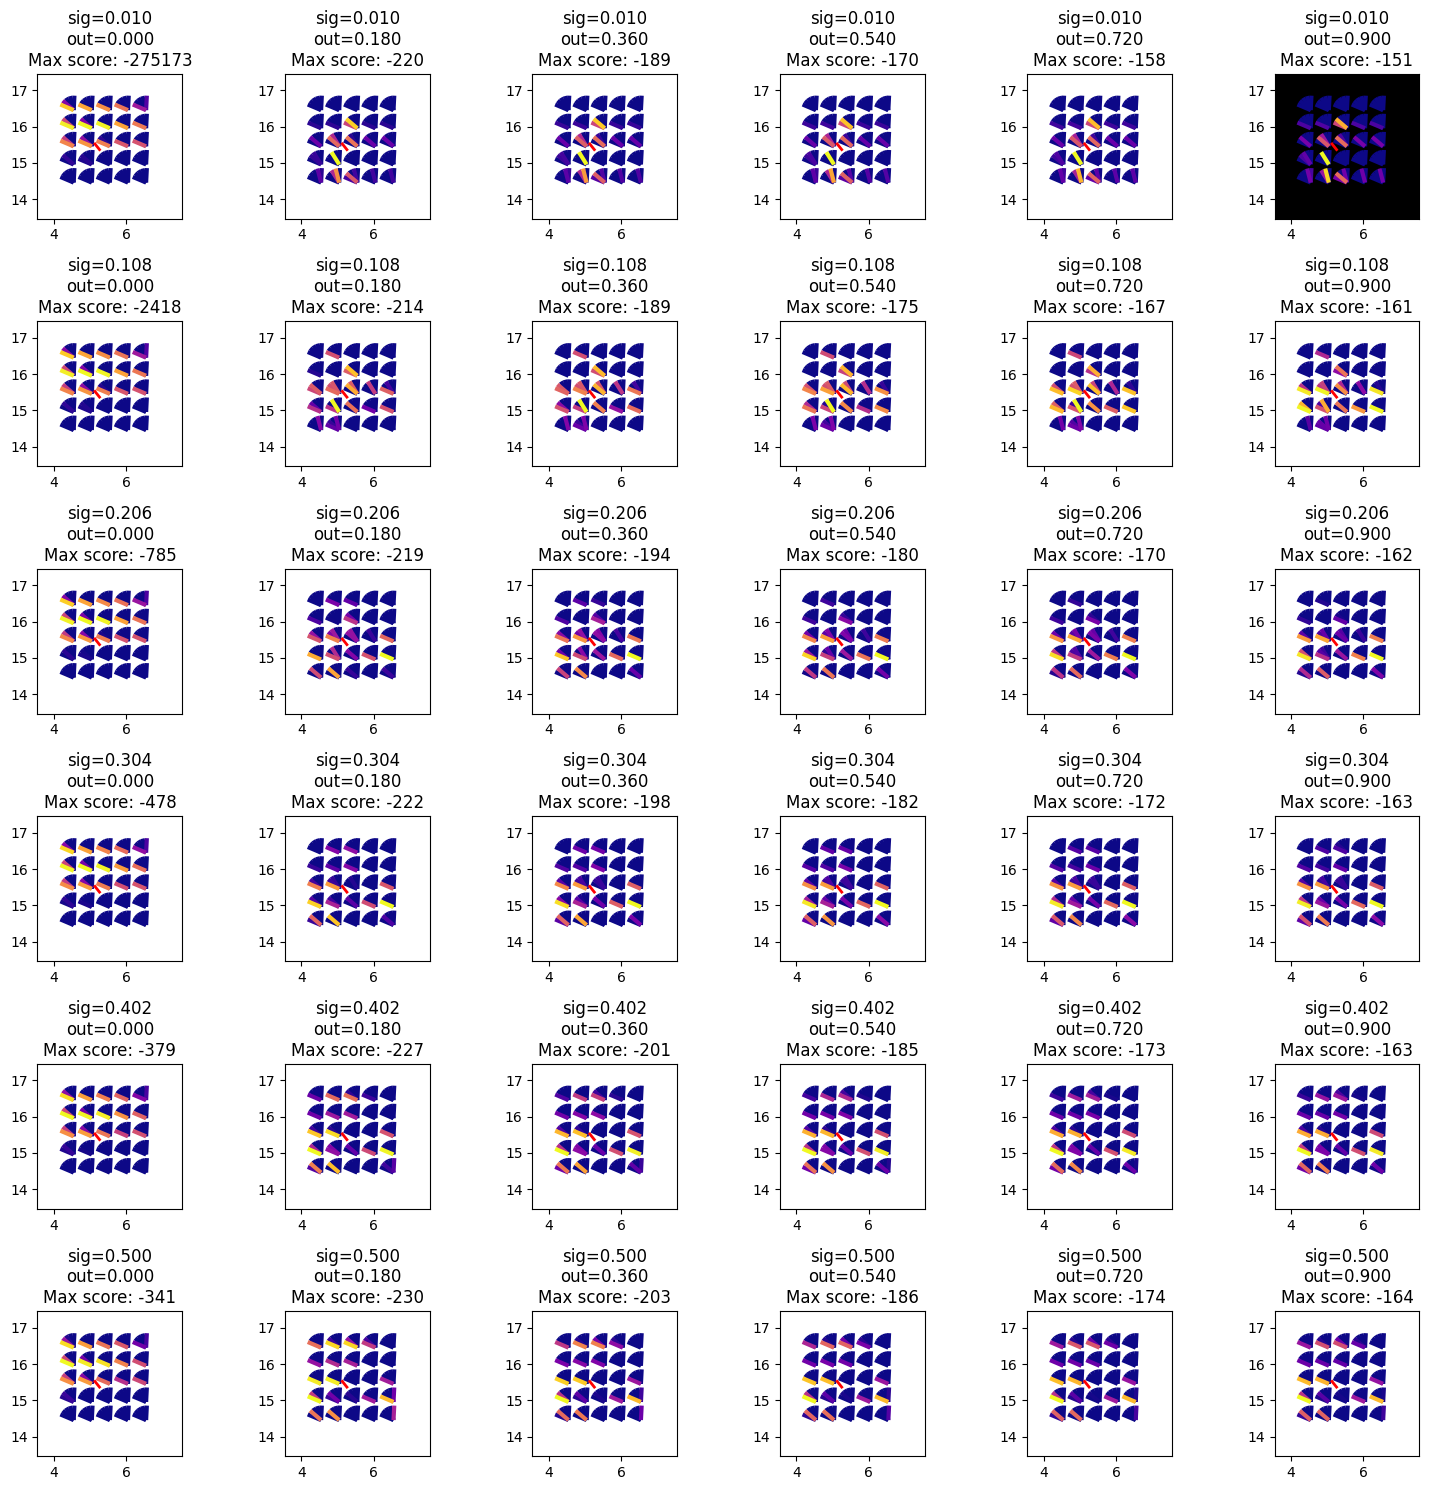

In [22]:
fig, axs = plt.subplots(*shape[3:], figsize=(15,15))


sc_marg = logsumexp(sc, axis=(0,1,2))
sc_marg = sc_marg - logsumexp(sc_marg)
sc_marg = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))
cs_marg  = plt.cm.binary(plt.Normalize()(jnp.exp(sc_marg)))


for i in range(shape[3]):
    for j in range(shape[4]):
        

        vs_ = vs[:,:,:,i,j].reshape(-1,5) 
        sc_ = sc[:,:,:,i,j].reshape(-1)

        order = jnp.argsort(sc_)
        sc_ = sc_[order]
        vs_ = vs_[order]
    
        sc__ = jnp.clip(sc_, -1e6,  jnp.max(sc_))
        sc__ = jnp.clip(sc__, jnp.quantile(sc__, 0.8), jnp.max(sc__))
        cs_  = plt.cm.plasma(plt.Normalize()(sc__))
    

        a = vs_[:,:2]
        b = a + 0.4 * jax.vmap(unit_vec)(vs_[:,2])

        seg_color = "k"

        # ---------------------
        ax = axs[i][j]
        ax.set_title(f"sig={vs_[0,3]:0.3f}\nout={vs_[0,4]:0.3f}\nMax score: {jnp.max(sc_):.0f}")
        ax.set_aspect(1)
        PAD = 2

        center = (vs[0,0,0,i,j,:2] + vs[-1,-1,0,i,j,:2])/2
        zoom_in(ax, center, PAD)
        ax.set_facecolor(cs_marg[i,j])

        ax.plot(
            *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
        c="r", zorder=4, linewidth=2)

        ax.add_collection(line_collection(a,b, c=cs_, zorder=1, linewidth=3));

fig.tight_layout()
fig.show()